# **Stock Price Prediction Using LSTM with Feature Engineering**
## **Overview**
This Python script implements a Long Short-Term Memory (LSTM) model to predict the next day's closing price of a stock. The model incorporates technical indicators such as RSI, OBV, SMA, and Bollinger Bands for feature engineering. The dataset is loaded from an SQLite database, preprocessed, and used to train and evaluate the LSTM model.

## **1. Imports**
The following libraries are imported for data processing, model development, and visualization

In [1]:
from sklearn.model_selection import train_test_split # For splitting the dataset into training and validation sets.
import tensorflow as tf # For building and training the LSTM model.

import matplotlib.pyplot as plt # For visualizing results.
import pandas as pd # For data manipulation and analysis.
import numpy as np # For numerical computations.
import sqlite3 # To interact with the SQLite database.
import ta # For calculating technical indicators.

## **2. Helper Functions**


In [2]:
def bollinger_band_squeeze(close):
    '''
        This function calculates the Bollinger Band Squeeze (BBS), a volatility indicator.

        Parameters:
            close:
                A pandas Series of closing prices.
        
        Returns:
            A pandas Series representing the Bollinger Band Squeeze.
    '''
    hband = ta.volatility.bollinger_hband(close, 20, 2)
    lband = ta.volatility.bollinger_lband(close, 20, 2)
    return (hband - lband) / close
    
def create_dataset(data, look_back, look_forward, label_name):
    '''
    This function prepares the dataset for LSTM by creating sequences of input features and corresponding labels.
    
    Parameters:
        data:
            The input dataset (pandas DataFrame).
        look_back:
            Number of time steps to use as input features.
        look_forward:
            Number of time steps to predict into the future.
        label_name:
            The column name of the target variable.
    
    Returns:
        X:
            Input sequences (numpy array).
        y:
            Target values (numpy array).
    '''
    X, y = [], []
    for i in range(len(data) - look_back - look_forward):
        X.append(data.iloc[i:(i + look_back), :])
        y.append(data.iloc[i + look_back + look_forward - 1, label_name])
    return np.array(X), np.array(y)
    
def compile_and_fit(model, X_train, y_train, X_valid, y_valid):
    '''
        This function compiles and trains the LSTM model. It includes early stopping to prevent overfitting.
        
        Parameters:
            model:
                ML model to be trained.
            X_train:
                Training data (features).
            y_train:
                Training labels (target).
            X_valid:
                Validation data (features).
            y_valid:
                Validation labels (target).
        
        Returns:
            history:
                Training history, including loss and metrics for each epoch.
    '''
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
        )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=8, mode='min'
    )
    
    history = model.fit(
        X_train, y_train,
        epochs=64,
        validation_data=(X_valid, y_valid),
        callbacks=[early_stopping]
    )
    
    return history

## **3. Data Loading and Preprocessing:**

In [3]:
## Loading Data from SQLite Database.
## The script connects to an SQLite database and retrieves  stock data for four companies: 
## TUPRS, ISMEN, KOZAL, and PENTA.
conn = sqlite3.connect('stocks.db')
cursor = conn.cursor()

cursor.execute("SELECT * FROM mature_stocks WHERE symbol IN ('TUPRS', 'ISMEN', 'KOZAL', 'PENTA') ORDER BY date, symbol")
records = pd.DataFrame(cursor.fetchall(), columns=('Date', 'Code', 'Open', 'High', 'Low', 'Close', 'Volume'))
conn.close()

## Data Transformation
## The data is transformed into a wide format, with each stock's metrics as separate columns.
records['Date'] = pd.to_datetime(records['Date'])
records = records.pivot(index='Date', columns='Code', values=['Open', 'High', 'Low', 'Close', 'Volume'])
records.columns = [f'{j}_{i}' for (i, j) in records.columns]

In [4]:
## Feature Engineering
## Technical indicators are calculated and added to the dataset:
## * RSI (Relative Strength Index)
## * OBV (On-Balance Volume)
## * SMA20 and SMA60 (Simple Moving Averages)
## * Bollinger Band Squeeze (BBS)
records['TUPRS_RSI'  ] = ta.momentum.rsi(records['TUPRS_Close'], 5)
records['TUPRS_OBV'  ] = ta.volume.on_balance_volume(records['TUPRS_Close'], records['TUPRS_Volume'])
records['TUPRS_SMA20'] = ta.trend.sma_indicator(records['TUPRS_Close'], 20)
records['TUPRS_SMA60'] = ta.trend.sma_indicator(records['TUPRS_Close'], 60)
records['TUPRS_BBS'  ] = bollinger_band_squeeze(records['TUPRS_Close'])

records = records.dropna()

In [5]:
## Creating Sequences
## The dataset is split into input sequences (X) and target values (y) using the 
## `create_dataset` function.

column_indices = {name: i for i, name in enumerate(records.columns)}
num_samples, num_features = records.shape

look_back    = 14
look_forward = 1

X, y = create_dataset(records, look_back, look_forward, column_indices['TUPRS_Close'])
print(f'Inputs shape (batch, time, features): {X.shape}')
print(f'Labels shape (batch, time, features): {y.shape}')

Inputs shape (batch, time, features): (702, 14, 25)
Labels shape (batch, time, features): (702,)


In [6]:
## Train-Validation Split
## The dataset is split into training and validation sets.

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

## Standardization
## The input data is standardized to have zero mean and unit variance.
## !! TO AVOID DATA LEAKAGE CONSTANST ARE CALCUTED FROM `train` DATASET
X_std, X_mean = X_train.std(axis=0), X_train.mean(axis=0)
y_std, y_mean = y_valid.std(axis=0), y_valid.mean(axis=0)

X_train, X_valid = (X_train - X_mean) / X_std, (X_valid - X_mean) / X_std
y_train, y_valid = (y_train - y_mean) / y_std, (y_valid - y_mean) / y_std

## **5. Model Development**

Epoch 1/64
18/18 [==============================] - 6s 83ms/step - loss: 0.2456 - mean_absolute_error: 0.3115 - val_loss: 0.0817 - val_mean_absolute_error: 0.0846
Epoch 2/64
18/18 [==============================] - 0s 23ms/step - loss: 0.1184 - mean_absolute_error: 0.1721 - val_loss: 0.0773 - val_mean_absolute_error: 0.0722
Epoch 3/64
18/18 [==============================] - 0s 25ms/step - loss: 0.1066 - mean_absolute_error: 0.1557 - val_loss: 0.0792 - val_mean_absolute_error: 0.0881
Epoch 4/64
18/18 [==============================] - 0s 23ms/step - loss: 0.0976 - mean_absolute_error: 0.1371 - val_loss: 0.0800 - val_mean_absolute_error: 0.0957
Epoch 5/64
18/18 [==============================] - 0s 23ms/step - loss: 0.0991 - mean_absolute_error: 0.1441 - val_loss: 0.0756 - val_mean_absolute_error: 0.0828
Epoch 6/64
18/18 [==============================] - 0s 25ms/step - loss: 0.0978 - mean_absolute_error: 0.1458 - val_loss: 0.0893 - val_mean_absolute_error: 0.1312
Epoch 7/64
18/18 [====

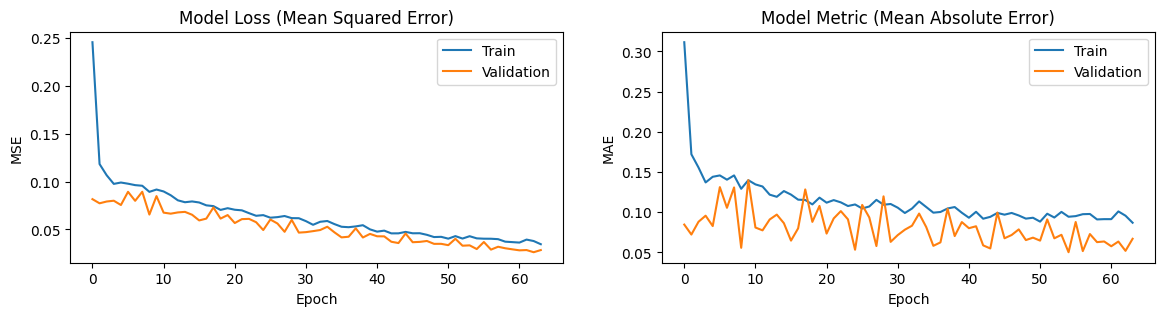

In [7]:
## LSTM Model Architecture
## The LSTM model consists of:
##     One LSTM layer with 128 units.
##     Two dense layers with 512 units and ReLU activation.
##     Dropout layers with a rate of 0.5 to prevent overfitting.
##     A final dense layer with 1 unit for regression.

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(look_back, num_features)),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

## Model Training
## The model is trained using the `compile_and_fit` function.
history = compile_and_fit(lstm_model, X_train, y_train, X_valid, y_valid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,3))

ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Model Loss (Mean Squared Error)')
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper right')


ax2.plot(history.history['mean_absolute_error'])
ax2.plot(history.history['val_mean_absolute_error'])
ax2.set_title('Model Metric (Mean Absolute Error)')
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper right')

plt.show()

## **6. Evaluation and Results**

In [8]:
## Prediction
## The model predicts the next day's closing price for the validation set.

y_pred = lstm_model.predict(X_valid)

results = pd.DataFrame({
    'y_valid': ((y_valid * y_std) + y_mean).flat,
    'y_pred' : ((y_pred  * y_std) + y_mean).flat
})

results.head(10)

5/5 [==============================] - 2s 14ms/step


,y_valid,y_pred
0,162.80,177.271942
1,65.03,60.556923
2,36.46,32.816933
3,144.00,143.735092
4,170.90,161.223862
5,143.70,136.429993
6,163.30,160.740479
7,145.50,140.762573
8,141.10,139.980698
9,152.60,149.443802


## **Conclusion**
This script demonstrates the use of LSTM for stock price prediction, incorporating feature engineering and technical indicators. The modular design allows for easy adaptation to other datasets or prediction tasks. Future improvements could include hyperparameter tuning, additional features, and ensemble modeling.

